In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1u8n45ho
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1u8n45ho
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done


In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog

register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Datos/DAWN2023-data-augmentation/train/_annotations.coco.json", "/content/drive/MyDrive/Datos/DAWN2023-data-augmentation/train")
register_coco_instances("my_dataset_valid", {}, "/content/drive/MyDrive/Datos/DAWN2023-data-augmentation/valid/_annotations.coco.json", "/content/drive/MyDrive/Datos/DAWN2023-data-augmentation/valid")

# Definir las clases (según la sección categories en _annotations.coco.json)
thing_classes = [
    "traffic-object", "auto rickshaw", "bicycle", "bus",
    "car", "motorbike", "pedestrian", "person", "truck"
]

# Asignar las clases manualmente a la metadata de train
MetadataCatalog.get("my_dataset_train").thing_classes = thing_classes

# Asignar las clases manualmente a la metadata de valid
MetadataCatalog.get("my_dataset_valid").thing_classes = thing_classes

# Verificar metadata
train_metadata = MetadataCatalog.get("my_dataset_train")
valid_metadata = MetadataCatalog.get("my_dataset_valid")

print("Clases del dataset (train):", train_metadata.thing_classes)
print("Clases del dataset (valid):", valid_metadata.thing_classes)

Clases del dataset (train): ['traffic-object', 'auto rickshaw', 'bicycle', 'bus', 'car', 'motorbike', 'pedestrian', 'person', 'truck']
Clases del dataset (valid): ['traffic-object', 'auto rickshaw', 'bicycle', 'bus', 'car', 'motorbike', 'pedestrian', 'person', 'truck']


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Number of training samples: 6558


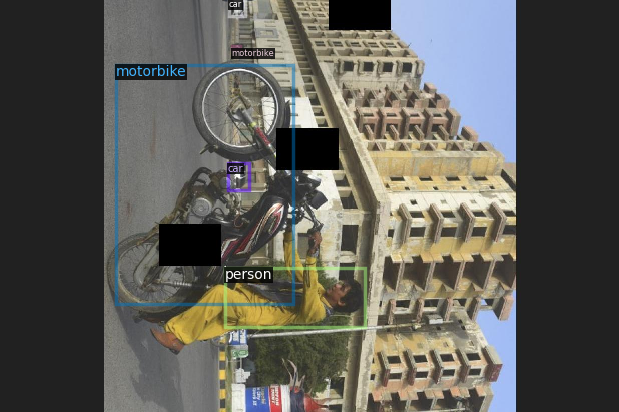

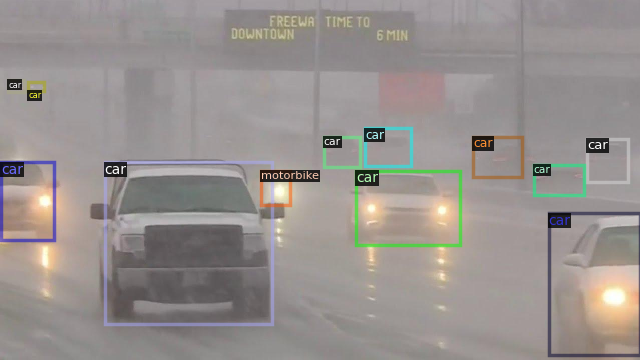

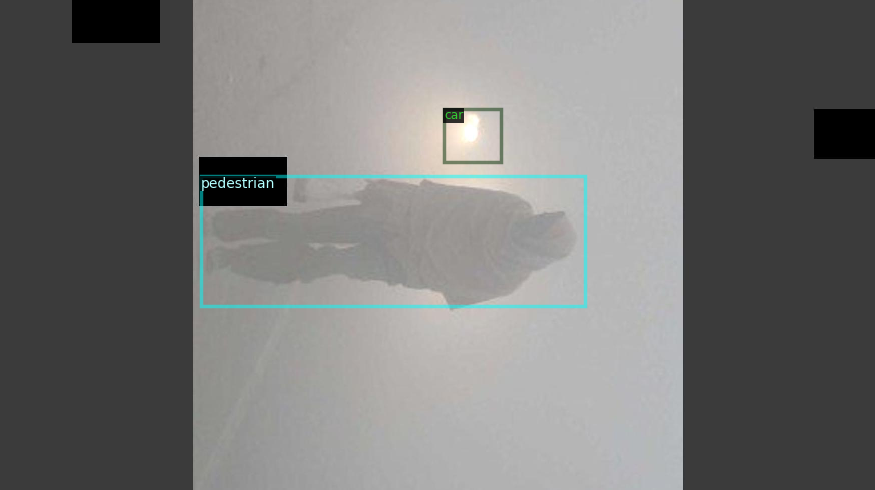

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog
from google.colab.patches import cv2_imshow

#visualize training data
dataset_dicts = DatasetCatalog.get("my_dataset_train")
print("Number of training samples:", len(dataset_dicts))

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
import os
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import torch

# Liberar memoria previa
torch.cuda.empty_cache()

# Configurar PyTorch para evitar fragmentación
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Configuración del modelo
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))

# Registrar datasets
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_valid",)

# Configuración de carga de datos
cfg.DATALOADER.NUM_WORKERS = 2  # Reducido para evitar sobrecargar CPU de Colab

# Pesos preentrenados
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")

# Configuración de entrenamiento ajustada para Colab
cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size pequeño para manejar memoria en Colab
cfg.SOLVER.MAX_ITER = 5000  # Ajustar iteraciones para un entrenamiento manejable
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = (4000, 4500)  # Reducir LR al 80% y 90%

# Configuración de ROI
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Reducir ROIs procesados por imagen
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # Número de clases en tu dataset

# Configuración del dispositivo
cfg.MODEL.DEVICE = "cuda"  # Asegúrate de seleccionar GPU en Colab

# Dimensiones de las imágenes ajustadas para Colab
cfg.INPUT.MIN_SIZE_TRAIN = (400,)  # Reducir tamaño mínimo para ahorrar memoria
cfg.INPUT.MAX_SIZE_TRAIN = 800
cfg.INPUT.MIN_SIZE_TEST = 400
cfg.INPUT.MAX_SIZE_TEST = 800

# Carpeta de salida
cfg.OUTPUT_DIR = "/content/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Entrenamiento
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluación
evaluator = COCOEvaluator("my_dataset_valid", cfg, False, output_dir=os.path.join(cfg.OUTPUT_DIR, "inference"))
val_loader = build_detection_test_loader(cfg, "my_dataset_valid")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


[11/26 15:59:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/26 16:00:00 d2.engine.train_loop]: Starting training from iteration 0
[11/26 16:00:12 d2.utils.events]:  eta: 0:38:27  iter: 19  total_loss: 3.277  loss_cls: 2.233  loss_box_reg: 0.8616  loss_rpn_cls: 0.08424  loss_rpn_loc: 0.04896    time: 0.5616  last_time: 0.2519  data_time: 0.3070  last_data_time: 0.0028   lr: 4.9953e-06  max_mem: 2823M
[11/26 16:00:21 d2.utils.events]:  eta: 0:35:18  iter: 39  total_loss: 3.147  loss_cls: 2.134  loss_box_reg: 0.9156  loss_rpn_cls: 0.08859  loss_rpn_loc: 0.03426    time: 0.5005  last_time: 0.4290  data_time: 0.1970  last_data_time: 0.1702   lr: 9.9902e-06  max_mem: 2823M
[11/26 16:00:30 d2.utils.events]:  eta: 0:33:46  iter: 59  total_loss: 2.824  loss_cls: 1.875  loss_box_reg: 0.812  loss_rpn_cls: 0.1565  loss_rpn_loc: 0.05401    time: 0.4894  last_time: 0.3940  data_time: 0.2145  last_data_time: 0.1298   lr: 1.4985e-05  max_mem: 2823M
[11/26 16:00:39 d2.utils.events]:  eta: 0:33:59  iter: 79  total_loss: 2.613  loss_cls: 1.555  loss_box_reg: 